In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re as re
import seaborn as sns
from scipy.stats import chi2_contingency

# Data processing

In [114]:
db_fraud = pd.read_csv(r"bs140513_032310.csv")
db_fraud.head(4)             #import and read the datafile

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0


In [115]:
db_fraud.drop(["zipcodeOri", "zipMerchant"], axis=1, inplace=True)
db_fraud.shape        #remove the zipcodes, they're unique

(594643, 8)

In [116]:
db_fraud.category.unique()

array(["'es_transportation'", "'es_health'", "'es_otherservices'",
       "'es_food'", "'es_hotelservices'", "'es_barsandrestaurants'",
       "'es_tech'", "'es_sportsandtoys'", "'es_wellnessandbeauty'",
       "'es_hyper'", "'es_fashion'", "'es_home'", "'es_contents'",
       "'es_travel'", "'es_leisure'"], dtype=object)

In [117]:
cols = ["customer", "age", "gender", "merchant","category"]
for col in cols:
    db_fraud[col]= db_fraud[col].apply(lambda x: x.replace('\'','')) #remove quotes from the columns
db_fraud.head(3)
db_fraud["category"].replace({"es_transportatio": "es_transportation"}, inplace=True) #correct the transavtion
#db_fraud["category"].replace(,[new_value1, new_value2, new_value3])
db_fraud.category.unique()

array(['es_transportation', 'es_health', 'es_otherservices', 'es_food',
       'es_hotelservices', 'es_barsandrestaurants', 'es_tech',
       'es_sportsandtoys', 'es_wellnessandbeauty', 'es_hyper',
       'es_fashion', 'es_home', 'es_contents', 'es_travel', 'es_leisure'],
      dtype=object)

In [118]:
db_fraud["category"].replace(['es_transportation', 'es_health', 'es_otherservices', 'es_food',
       'es_hotelservices', 'es_barsandrestaurants', 'es_tech',
       'es_sportsandtoys', 'es_wellnessandbeauty', 'es_hyper',
       'es_fashion', 'es_home', 'es_contents', 'es_travel', 'es_leisure'],['transportation', 'health', 'otherservices', 'food',
       'hotelservices', 'barsandrestaurants', 'tech',
       'sportsandtoys', 'wellnessandbeauty', 'hyper',
       'fashion', 'home', 'contents', 'travel', 'leisure'], inplace=True)

In [119]:
db_fraud.info()
db_fraud[db_fraud.category.isna()==True]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  
 1   customer  594643 non-null  object 
 2   age       594643 non-null  object 
 3   gender    594643 non-null  object 
 4   merchant  594643 non-null  object 
 5   category  594643 non-null  object 
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 36.3+ MB


,step,customer,age,gender,merchant,category,amount,fraud


In [120]:
for col in db_fraud.columns:
  data = db_fraud[col].nunique()
  print(f"{col} has {data} differents modalities.\n")

step has 180 differents modalities.

customer has 4112 differents modalities.

age has 8 differents modalities.

gender has 4 differents modalities.

merchant has 50 differents modalities.

category has 15 differents modalities.

amount has 23767 differents modalities.

fraud has 2 differents modalities.



In [121]:
#db_fraud["fraud"] = db_fraud["fraud"].apply(lambda x: "1" if x==1 else "0")

In [122]:
#db_fraud["age"] = db_fraud["age"].apply(lambda x: int(x) if x!="U" else np.NaN) #correct the type of age
db_fraud["ageCateg"] = db_fraud["age"].apply(lambda x: str(x)+' years' if x!=np.NaN else "Unknown") #make age a categoric year

In [123]:
db_fraud.describe(include="all")

,step,customer,age,gender,merchant,category,amount,fraud,ageCateg
count,594643.000000,594643,594643,594643,594643,594643,594643.000000,594643.000000,594643
unique,NaN,4112,8,4,50,15,NaN,NaN,8
top,NaN,C1978250683,2,F,M1823072687,transportation,NaN,NaN,2 years
freq,NaN,265,187310,324565,299693,505119,NaN,NaN,187310
mean,94.986827,NaN,NaN,NaN,NaN,NaN,37.890135,0.012108,NaN
std,51.053632,NaN,NaN,NaN,NaN,NaN,111.402831,0.109369,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,52.000000,NaN,NaN,NaN,NaN,NaN,13.740000,0.000000,NaN
50%,97.000000,NaN,NaN,NaN,NaN,NaN,26.900000,0.000000,NaN
75%,139.000000,NaN,NaN,NaN,NaN,NaN,42.540000,0.000000,NaN


In [124]:
def dummies_create(value, data=db_fraud):
  x=pd.get_dummies(data[value])
  return x
a = dummies_create(value="gender")
b = dummies_create(value="category")
c = dummies_create(value="customer")
d = dummies_create(value="merchant")
e = dummies_create(value="ageCateg") 
 #create dummies of each categorical variable


**Creation of dummies**

In [125]:
pv_categ=db_fraud.pivot_table(index="step", columns="category", values="amount", aggfunc=np.sum)
pv_gender=db_fraud.pivot_table(index="step", columns="gender", values="amount", aggfunc=np.sum)
pv_ageC=db_fraud.pivot_table(index="step", columns="ageCateg", values="amount", aggfunc=np.sum)
pv_fraud=db_fraud.pivot_table(index="step", columns="fraud", values="amount", aggfunc=np.sum)
pv_categ_age=db_fraud.pivot_table(index="category", columns="ageCateg", values="amount", aggfunc="count")

# Statistics and probability

In [126]:
def tab(col, data=db_fraud):
  tab = pd.DataFrame()
  tab["Total"] = data[col].value_counts(normalize=False)
  tab["freq"] = data[col].value_counts(normalize=True)
  amount_tab = pd.pivot_table(data=db_fraud, index= col, values='amount', aggfunc='sum')
  amount_tab = pd.pivot_table(data=db_fraud, index= col, values='amount', aggfunc='sum').sort_values(by="amount", ascending=False)
  nb_unique = len(tab)
  return tab, amount_tab, nb_unique   #this function returns a table with the columns: total and frequence for each category.

In [127]:
fraud, amount_fraud, nb_fraud = tab(col = "fraud")
gender, amount_gender, nb_gender = tab(col = "gender")
category, amount_categ, nb_category = tab(col = "category")
customer, amount_custom, nb_customer = tab(col = "customer")
merchant, amount_merchant, nb_merchant = tab(col="merchant")
step, amount_step, nb_step = tab(col = "step")
age_categ, amount_age_categ, nb_age_categ = tab(col="ageCateg")
amount_custom.sort_values(by="amount", ascending=False)

,amount
step,
0,92563.27
1,101662.95
2,102285.39
3,107622.07
4,104445.74
...,...
175,132514.09
176,130933.45
177,133461.82


In [128]:
def tab_cross(col1, col2, data=db_fraud):
    tb = pd.crosstab(data[col1], data[col2], margins= True, normalize=False)
    tb1 = pd.crosstab(data[col1], data[col2], margins= True, normalize=True)
    tb2 = pd.crosstab(data[col1], data[col2], margins= True, normalize="columns")
    tb3 = pd.crosstab(data[col1], data[col2], margins= True, normalize="index")
    chi2, pval, dof, expected = chi2_contingency(tb.iloc[:-1, :-1])
    return tb, tb1, tb2, tb3, pval                                            #realize different types of croosstable on the data

In [129]:
#crosstable for fraud and gender and probability calculus
tb_gen_fraud, tb1_gen_fraud, tb2_gen_fraud, tb3_gen_fraud, pval1 = tab_cross(col1 ="gender", col2="fraud")

#crosstable for category and fraud probability calculus
tb_categ_fraud, tb1_categ_fraud, tb2_categ_fraud, tb3_categ_fraud, pval2 = tab_cross(col1 ="category", col2="fraud")

#crosstable for age and fraud probability calculus
tb_age_fraud, tb1_age_fraud, tb2_age_fraud, tb3_age_fraud, pval3 = tab_cross(col1 = "age" , col2= "fraud")

In [177]:
tb3_categ_fraud.T

category,barsandrestaurants,contents,fashion,food,health,home,hotelservices,hyper,leisure,otherservices,sportsandtoys,tech,transportation,travel,wellnessandbeauty,All
fraud,,,,,,,,,,,,,,,,
0,0.981171,1.0,0.982027,1.0,0.894874,0.847936,0.68578,0.954083,0.0501,0.75,0.504748,0.933333,1.0,0.206044,0.952406,0.987892
1,0.018829,0.0,0.017973,0.0,0.105126,0.152064,0.31422,0.045917,0.9499,0.25,0.495252,0.066667,0.0,0.793956,0.047594,0.012108


In [131]:
x = db_fraud[db_fraud["fraud"]==1]
x = x[["category"]]
y = x.value_counts(normalize=True)
y

category          
sportsandtoys         0.275278
health                0.235556
wellnessandbeauty     0.099722
travel                0.080278
hotelservices         0.076111
leisure               0.065833
home                  0.041944
hyper                 0.038889
otherservices         0.031667
tech                  0.021944
barsandrestaurants    0.016667
fashion               0.016111
dtype: float64

In [132]:
amount_day = db_fraud[["amount","step", "category"]].groupby(pd.Grouper(key="step")).sum()

In [133]:
tb_gen_fraud

fraud,0,1,All
gender,,,
E,1171,7,1178
F,319807,4758,324565
M,265950,2435,268385
U,515,0,515
All,587443,7200,594643


**The marginal probability**

In [172]:
tb3_age_fraud

fraud,0,1
age,,
0,0.980424,0.019576
1,0.988147,0.011853
2,0.987486,0.012514
3,0.988072,0.011928
4,0.987067,0.012933
5,0.989049,0.010951
6,0.990252,0.009748
U,0.994058,0.005942
All,0.987892,0.012108


In [173]:
tb3_categ_fraud

fraud,0,1
category,,
barsandrestaurants,0.981171,0.018829
contents,1.000000,0.000000
fashion,0.982027,0.017973
food,1.000000,0.000000
health,0.894874,0.105126
home,0.847936,0.152064
hotelservices,0.685780,0.314220
hyper,0.954083,0.045917
leisure,0.050100,0.949900


In [174]:
tb3_gen_fraud

fraud,0,1
gender,,
E,0.994058,0.005942
F,0.985340,0.014660
M,0.990927,0.009073
U,1.000000,0.000000
All,0.987892,0.012108


# Exploratory Data Analysis

UNIVARIATE ANALYSIS

In [176]:
fraud

,Total,freq
0,587443,0.987892
1,7200,0.012108


No handles with labels found to put in legend.


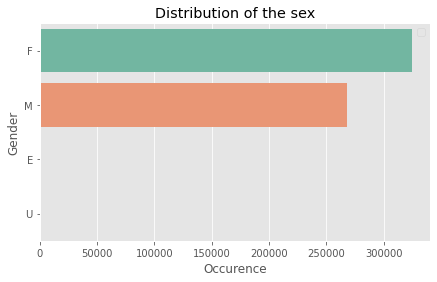

In [136]:
def myplot(data, title="",label="Occurence",y="", figsize = (8,5)):
    plt.style.use("ggplot")
    plt.figure(figsize=figsize)
    sns.set_palette('Set2')
    sns.barplot(y=data.index,  x= data.Total)
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel(y)
    plt.legend()
    plt.show
myplot(gender[:], title="Distribution of the sex", y="Gender", figsize=(7,4))

No handles with labels found to put in legend.


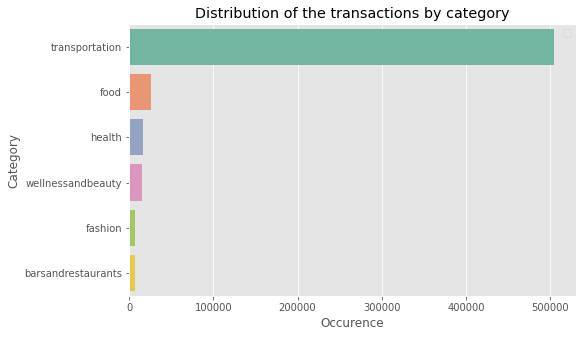

In [137]:
myplot(category[:6], title="Distribution of the transactions by category", y="Category")

No handles with labels found to put in legend.


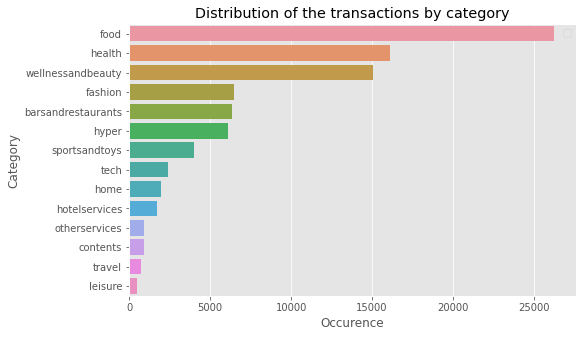

In [163]:
myplot(category[1:], title="Distribution of the transactions by category", y="Category")

No handles with labels found to put in legend.


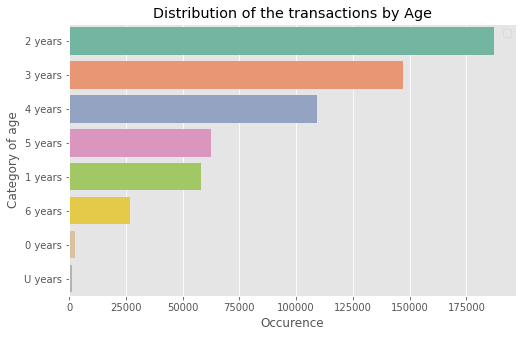

In [138]:
myplot(age_categ, title="Distribution of the transactions by Age", y="Category of age")

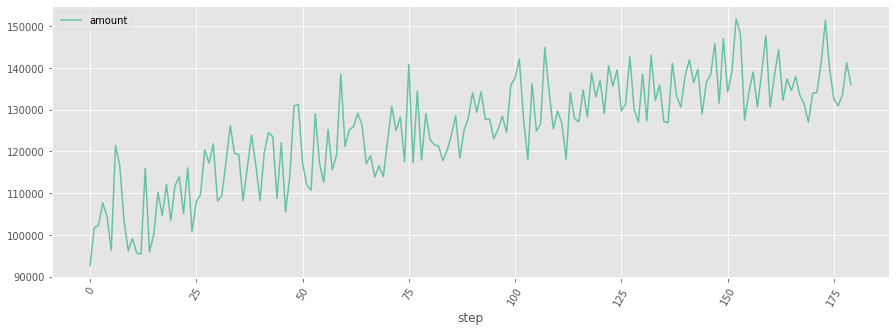

In [139]:
fig, ax = plt.subplots(figsize=(15,5))
amount_day.reset_index().plot.line(x = "step", y = ["amount"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

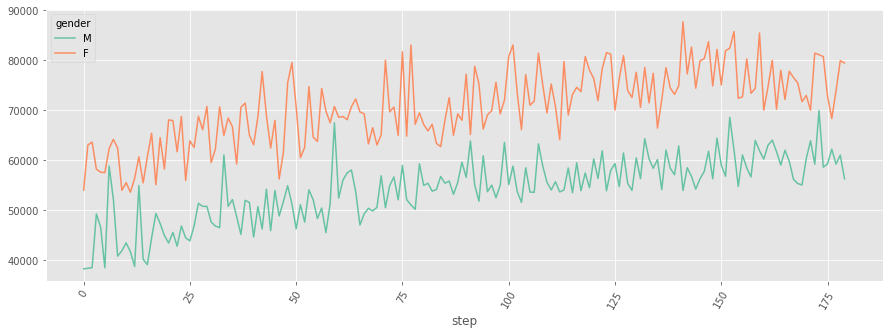

In [140]:
fig, ax = plt.subplots(figsize=(15,5))
pv_gender.reset_index().plot.line(x = "step", y = ["M", "F"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

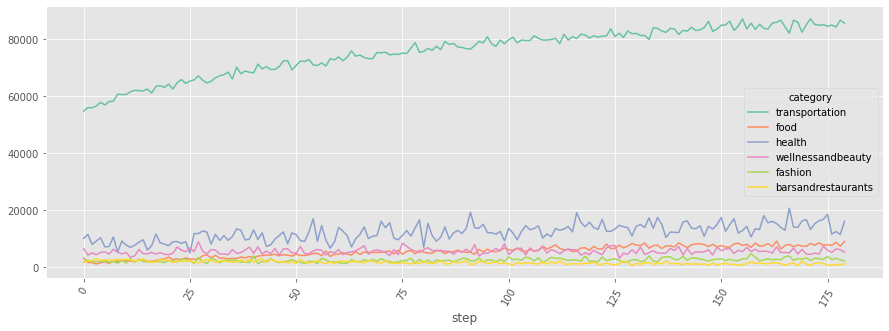

In [141]:
fig, ax = plt.subplots(figsize=(15,5))
pv_categ.reset_index().plot.line(x = "step", y =["transportation" ,"food", "health", "wellnessandbeauty", "fashion", "barsandrestaurants"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

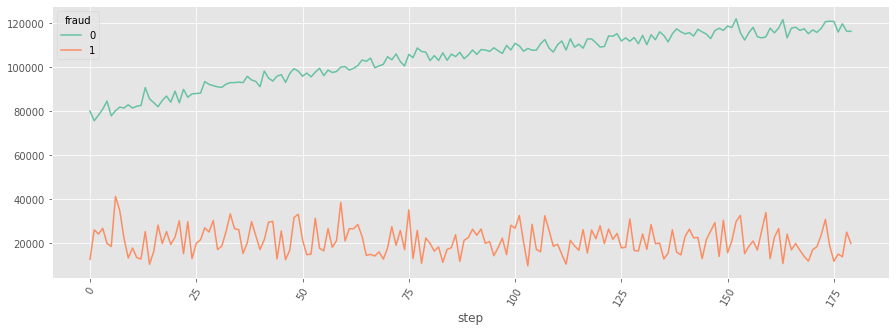

In [142]:
fig, ax = plt.subplots(figsize=(15,5))
pv_fraud.reset_index().plot.line(x = "step", y =[0,1], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb91a62110>]],
      dtype=object)

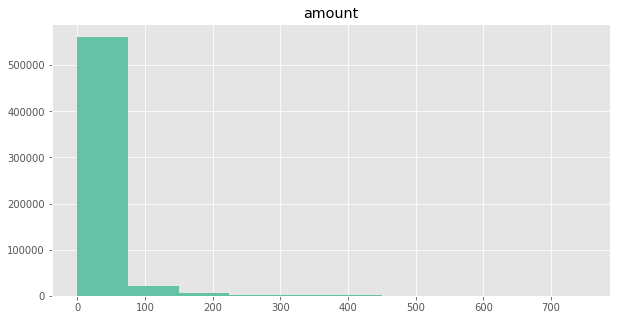

In [143]:
db_fraud[db_fraud.amount<750].hist(column="amount", figsize=(10,5))

# Modeling

# Result

Thoughts on fraudulent transactions

In [144]:
fraud_transac = db_fraud[db_fraud["fraud"]==1]
fraud_transac.head(2)

,step,customer,age,gender,merchant,category,amount,fraud,ageCateg
88,0,C583110837,3,M,M480139044,health,44.26,1,3 years
89,0,C1332295774,3,M,M480139044,health,324.50,1,3 years


In [175]:
fraud

,Total,freq
0,587443,0.987892
1,7200,0.012108


We have 

In [145]:
fraud_transac.amount.sum()

3822671.1700000004

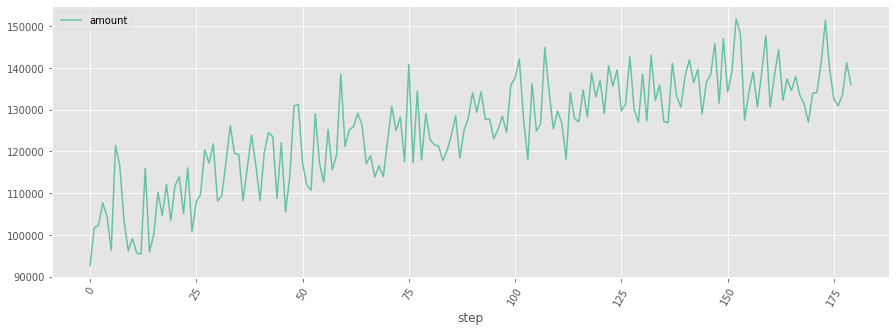

In [146]:
amount_day1 = db_fraud[["amount","step", "category"]].groupby(pd.Grouper(key="step")).sum()
fig, ax = plt.subplots(figsize=(15,5))
amount_day1.reset_index().plot.line(x = "step", y = ["amount"], rot = 60, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

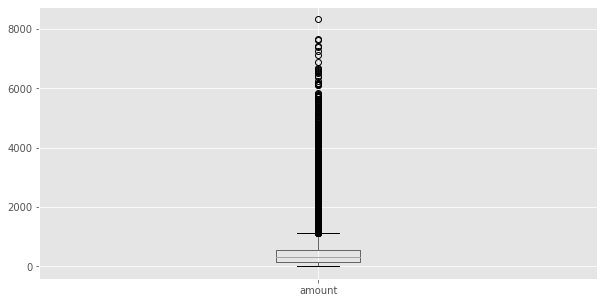

In [147]:
fraud_transac.boxplot(column="amount",figsize=(10,5))

In [148]:
#fraud_transac[fraud_transac["amount"]].hist(column="amount", figsize=(10,5))

Fraudulent transactions tend to increase day by day. What is amazing to note is that there are frauds every day, so the control must be pushed continuously. Hence the urgency for the bank to solve the problem as soon as possible otherwise it risks losing many of its customers.

In [149]:
print(tb3_gen_fraud)
print("We performed a chi-square test to see if gender has some dependence on whether one is a victim of fraud or not. \nThe {pval1} in inferior to 0.05")
print("We conclude that there is dependency between gender and fraud.")
print("A woman would be more exposed to fraud than a man and those who do not specify their sex are less at risk. In fact, none of them were victims.")

fraud          0         1
gender                    
E       0.994058  0.005942
F       0.985340  0.014660
M       0.990927  0.009073
U       1.000000  0.000000
All     0.987892  0.012108
We performed a chi-square test to see if gender has some dependence on whether one is a victim of fraud or not. 
The {pval1} in inferior to 0.05
We conclude that there is dependency between gender and fraud.
A woman would be more exposed to fraud than a man and those who do not specify their sex are less at risk. In fact, none of them were victims.


In [150]:
tb1_gen_fraud
tb_categ_fraud

fraud,0,1,All
category,,,
barsandrestaurants,6253,120,6373
contents,885,0,885
fashion,6338,116,6454
food,26254,0,26254
health,14437,1696,16133
home,1684,302,1986
hotelservices,1196,548,1744
hyper,5818,280,6098
leisure,25,474,499


Text(0.5, 1.0, 'Sex by fraudulent transactions')

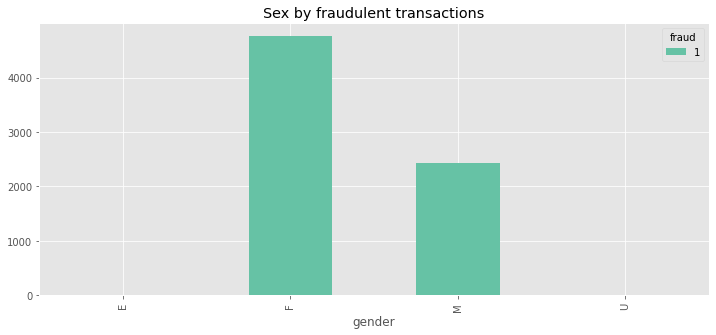

In [151]:
plot1 = tb_gen_fraud.iloc[:-1, 1:2].plot(kind="bar", figsize=(12,5))
plt.title("Sex by fraudulent transactions")

In [178]:
tb3_gen_fraud

fraud,0,1
gender,,
E,0.994058,0.005942
F,0.985340,0.014660
M,0.990927,0.009073
U,1.000000,0.000000
All,0.987892,0.012108


In [152]:
print(tb3_categ_fraud)
print("We performed a chi-square test to see if category has some dependence on whether one is a victim of fraud or not. \nThe {pval1} in inferior to 0.05")
print("We conclude that there is dependency between category and fraud.")
print("The leisure service would be more exposed to fraud, 94% ot them are fraudulent. Food, contents and transportation are not at risk. In fact, none of them were victims.")

fraud                      0         1
category                              
barsandrestaurants  0.981171  0.018829
contents            1.000000  0.000000
fashion             0.982027  0.017973
food                1.000000  0.000000
health              0.894874  0.105126
home                0.847936  0.152064
hotelservices       0.685780  0.314220
hyper               0.954083  0.045917
leisure             0.050100  0.949900
otherservices       0.750000  0.250000
sportsandtoys       0.504748  0.495252
tech                0.933333  0.066667
transportation      1.000000  0.000000
travel              0.206044  0.793956
wellnessandbeauty   0.952406  0.047594
All                 0.987892  0.012108
We performed a chi-square test to see if category has some dependence on whether one is a victim of fraud or not. 
The {pval1} in inferior to 0.05
We conclude that there is dependency between category and fraud.
The leisure service would be more exposed to fraud, 94% ot them are fraudulent. Food, 

Text(0.5, 1.0, 'Age by fraudulent transactions')

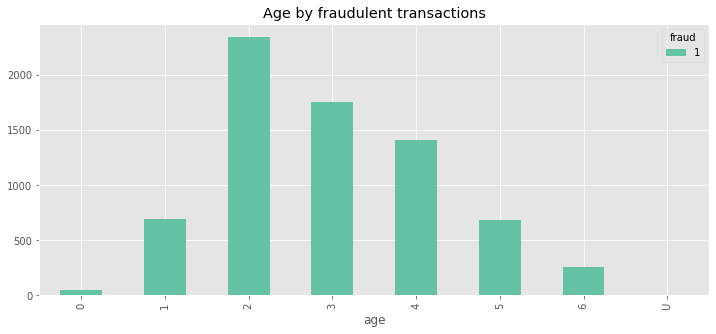

In [153]:
plot1 = tb_age_fraud.iloc[:-1, 1:2].plot(kind="bar", figsize=(12,5))
plt.title("Age by fraudulent transactions")


The second class, 18-25 years old, is the most victimized age range among the fraudulent transactions.

Text(0.5, 1.0, 'Category by fraudulent transactions')

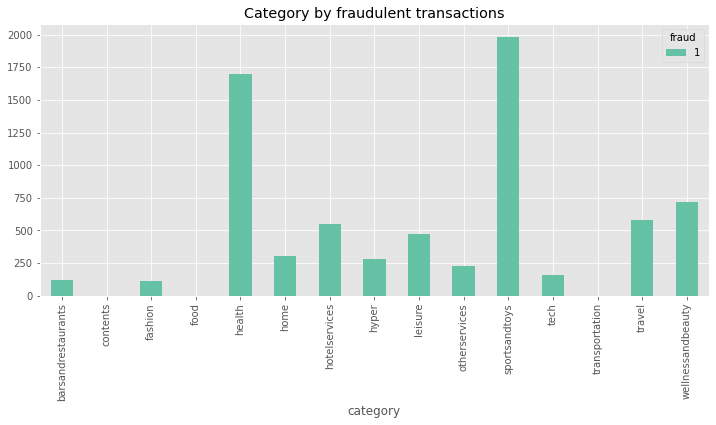

In [154]:
plot1 = tb_categ_fraud.iloc[:-1, 1:2].plot(kind="bar", figsize=(12,5))
plt.title("Category by fraudulent transactions")

Sports and toys is the most used service among the fraudulent transactions

In **sport and health**, there is a greater amount of fraudulent transactions.

In [155]:
#Create class of amount
db_fraud1 = db_fraud.reset_index()
db_fraud1['ZZ']=pd.cut(db_fraud1.amount.values,90,ordered=True)
# Summarise dataframe using pivot table: Fraud & Class of amount
fraud_amount_bank_pivot1=pd.pivot_table(db_fraud1,values="index", index=['fraud',],
columns=['ZZ'], aggfunc="count",fill_value =0)
#Apply Test
stat, p, dof, expected = chi2_contingency(fraud_amount_bank_pivot1.values)
print("p-values:",p)
if p < 0.05:
 print("Hypothesis Rejected")
else:
 print("Hypothesis Accepted")
fraud_amount_bank_pivot1

p-values: 0.0
Hypothesis Rejected


ZZ,"(-8.33, 92.555]","(92.555, 185.11]","(185.11, 277.665]","(277.665, 370.22]","(370.22, 462.776]","(462.776, 555.331]","(555.331, 647.886]","(647.886, 740.441]","(740.441, 832.996]","(832.996, 925.551]","(925.551, 1018.106]","(1018.106, 1110.661]","(1110.661, 1203.216]","(1203.216, 1295.772]","(1295.772, 1388.327]","(1388.327, 1480.882]","(1480.882, 1573.437]","(1573.437, 1665.992]","(1665.992, 1758.547]","(1758.547, 1851.102]","(1851.102, 1943.657]","(1943.657, 2036.212]","(2036.212, 2128.768]","(2128.768, 2221.323]","(2221.323, 2313.878]","(2313.878, 2406.433]","(2406.433, 2498.988]","(2498.988, 2591.543]","(2591.543, 2684.098]","(2684.098, 2776.653]","(2776.653, 2869.208]","(2869.208, 2961.764]","(2961.764, 3054.319]","(3054.319, 3146.874]","(3146.874, 3239.429]","(3239.429, 3331.984]","(3331.984, 3424.539]","(3424.539, 3517.094]","(3517.094, 3609.649]","(3609.649, 3702.204]","(3702.204, 3794.76]","(3794.76, 3887.315]","(3887.315, 3979.87]","(3979.87, 4072.425]","(4072.425, 4164.98]","(4164.98, 4257.535]","(4257.535, 4350.09]","(4350.09, 4442.645]","(4442.645, 4535.2]","(4535.2, 4627.756]","(4627.756, 4720.311]","(4720.311, 4812.866]","(4812.866, 4905.421]","(4905.421, 4997.976]","(4997.976, 5090.531]","(5090.531, 5183.086]","(5183.086, 5275.641]","(5275.641, 5368.196]","(5368.196, 5460.752]","(5460.752, 5553.307]","(5553.307, 5645.862]","(5645.862, 5738.417]","(5738.417, 5830.972]","(5830.972, 5923.527]","(6108.637, 6201.192]","(6201.192, 6293.748]","(6293.748, 6386.303]","(6386.303, 6478.858]","(6478.858, 6571.413]","(6571.413, 6663.968]","(6663.968, 6756.523]","(6849.078, 6941.633]","(7126.744, 7219.299]","(7219.299, 7311.854]","(7311.854, 7404.409]","(7404.409, 7496.964]","(7589.519, 7682.074]","(8237.405, 8329.96]"
fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,570585,13361,2815,502,85,15,8,13,11,11,7,2,2,9,3,2,5,1,0,2,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1059,1007,1053,1046,736,529,426,288,223,155,93,72,42,14,19,23,13,10,7,17,15,16,11,9,10,14,13,7,11,10,12,14,8,13,6,6,11,3,9,12,6,7,7,11,6,13,6,5,3,5,8,12,4,6,1,4,4,5,2,5,2,6,5,1,7,1,1,1,2,3,1,1,1,1,1,1,2,1


In [171]:
db_fraud2=db_fraud.copy()
db_fraud2["Class_amount"] = db_fraud["amount"].apply(lambda x: "inf to 2000" if x<2000 else "Sup to 2000")
pv_fraude2=db_fraud2.pivot_table(index="Class_amount", columns="fraud", values="amount", aggfunc="count")
pv_fraude2

fraud,0,1
Class_amount,,
Sup to 2000,1,343
inf to 2000,587442,6857


We have shown that there is a dependency between the amount of purchases and whether there is fraud or not.  The pivot table above shows that from 2000 dollars for a transaction, there are no more safe transactions. The bank needs to increase control over these transactions.

The reduction on frauds if we cancel the transactions over 2000 because they are mostly fraudulent.

In [156]:
fraud_transac[fraud_transac["amount"]>2000]["amount"].sum()

1298859.8499999999

The reduction on frauds if we cancel the transactions for the leisure services.

In [157]:
fraud_transac[fraud_transac.category=="leisure"]["amount"].sum()

142335.97999999998

In [158]:
pv_categ_age

ageCateg,0 years,1 years,2 years,3 years,4 years,5 years,6 years,U years
category,,,,,,,,
barsandrestaurants,32.0,606.0,2093.0,1488.0,1153.0,680.0,307.0,14.0
contents,4.0,99.0,282.0,235.0,145.0,84.0,32.0,4.0
fashion,38.0,613.0,1977.0,1671.0,1214.0,672.0,257.0,12.0
food,123.0,2589.0,8220.0,6739.0,4760.0,2719.0,1040.0,64.0
health,113.0,1676.0,5080.0,4048.0,2957.0,1526.0,687.0,46.0
home,12.0,196.0,610.0,486.0,392.0,200.0,88.0,2.0
hotelservices,5.0,178.0,552.0,428.0,319.0,183.0,71.0,8.0
hyper,25.0,541.0,1941.0,1448.0,1145.0,662.0,322.0,14.0
leisure,5.0,58.0,135.0,138.0,88.0,54.0,20.0,1.0


Transportation is the most used service and we found out that no fraudulent transactions have not been done for this.
